<a href="https://colab.research.google.com/github/SaumilShah-7/Dog-Breed-Identification-Kaggle/blob/master/Dog_Breed_Identification_Kaggle%20(using%20ResNet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image
import os
import math
import shutil
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

**Upload kaggle.json file and download competition data**

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c dog-breed-identification

In [0]:
!unzip -q -o train.zip
!unzip -q -o test.zip
!unzip -q -o labels.csv.zip
!rm train.zip
!rm test.zip
!rm labels.csv.zip

In [0]:
y_df = pd.read_csv('labels.csv')

# print(y_df['breed'].value_counts())

y_breed = np.asarray(y_df['breed']).reshape(-1, 1)
ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(y_breed)

labels_mapping = {np.argmax(y[i]): y_df.loc[i,'breed'] for i in range(len(y))}

image_height = 224
image_width = 224

x = []
for i in y_df['id']:
  image = Image.open('/content/train/'+i+'.jpg')
  x.append(np.array(image.resize((image_height, image_width))))
x = np.asarray(x)

print(x.shape)

**Stratified train-validation split to ensure class balance**

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7, shuffle=True, stratify=y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, len(set([np.argmax(i) for i in y_train])), len(set([np.argmax(i) for i in y_test])))

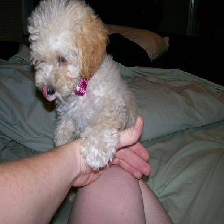

In [0]:
img = Image.fromarray(x_train[0])
img

**Transfer learning approach: Tried VGG16 & ResNet50 architectures; chose the latter**

In [0]:
RN50 = ResNet50(include_top=False, weights='imagenet', input_shape=(image_height, image_width, 3))

x_train_features = RN50.predict(preprocess_input(x_train))
x_test_features = RN50.predict(preprocess_input(x_test))

In [0]:
model = Sequential()

model.add(Flatten(input_shape=x_train_features.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(units=240, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=120, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 240)               24084720  
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               28920     
Total params: 24,113,640
Trainable params: 24,113,640
Non-trainable params: 0
_________________________________________________________________
None


**Optimizers tried: SGD, Adam & RMSprop; chose SGD due to better & faster convergence**

Train on 8177 samples, validate on 2045 samples
Epoch 1/50
7680/8177 [===========================>..] - ETA: 0s - loss: 5.3169 - accuracy: 0.0219
Epoch 00001: val_accuracy improved from -inf to 0.08606, saving model to best_model.h5
8177/8177 [==============================] - 4s 455us/sample - loss: 5.2720 - accuracy: 0.0236 - val_loss: 4.4199 - val_accuracy: 0.0861
Epoch 2/50
7680/8177 [===========================>..] - ETA: 0s - loss: 4.1307 - accuracy: 0.0993
Epoch 00002: val_accuracy improved from 0.08606 to 0.26699, saving model to best_model.h5
8177/8177 [==============================] - 2s 265us/sample - loss: 4.1062 - accuracy: 0.1033 - val_loss: 3.3887 - val_accuracy: 0.2670
Epoch 3/50
7680/8177 [===========================>..] - ETA: 0s - loss: 3.3025 - accuracy: 0.2424
Epoch 00003: val_accuracy improved from 0.26699 to 0.41418, saving model to best_model.h5
8177/8177 [==============================] - 2s 266us/sample - loss: 3.2897 - accuracy: 0.2439 - val_loss: 2.5750 - v

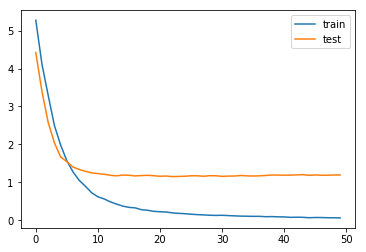

In [0]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

batch_size = 512
nb_epochs = 50

history = model.fit(x_train_features, y_train, batch_size=batch_size, epochs=nb_epochs, validation_data=[x_test_features, y_test], callbacks=[mc])

saved_model = load_model('best_model.h5')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

**Figure out top misclassifications**

In [0]:
y_test_pred = saved_model.predict(x_test_features)
y_test_pred_id = np.argmax(y_test_pred, axis=1).reshape(-1, 1)
y_test_id = np.argmax(y_test, axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(confusion_matrix(y_test_id, y_test_pred_id), index=[labels_mapping[i] for i in range(len(labels_mapping))], 
                                            columns=[labels_mapping[i] for i in range(len(labels_mapping))])

most_confused = []
for i in range(len(labels_mapping)):
               most_confused.append((df_cm.index[i], df_cm.iloc[i, df_cm.columns!=df_cm.index[i]].idxmax(), df_cm.iloc[i, df_cm.columns!=df_cm.index[i]].max(axis=0), df_cm.iloc[i].sum(axis=0)))
most_confused.sort(key = lambda x: x[2], reverse = True)

# print(sum(x for _,_,_,x in most_confused))
print(most_confused)

[('toy_poodle', 'miniature_poodle', 10, 16), ('eskimo_dog', 'siberian_husky', 8, 13), ('miniature_poodle', 'standard_poodle', 6, 16), ('irish_wolfhound', 'scottish_deerhound', 5, 20), ('shih-tzu', 'lhasa', 5, 23), ('silky_terrier', 'australian_terrier', 5, 18), ('airedale', 'lakeland_terrier', 4, 22), ('collie', 'border_collie', 4, 17), ('doberman', 'miniature_pinscher', 4, 15), ('great_pyrenees', 'kuvasz', 4, 22), ('scottish_deerhound', 'irish_wolfhound', 4, 25), ('staffordshire_bullterrier', 'american_staffordshire_terrier', 4, 16), ('walker_hound', 'basset', 4, 14), ('american_staffordshire_terrier', 'staffordshire_bullterrier', 3, 15), ('basset', 'walker_hound', 3, 16), ('beagle', 'walker_hound', 3, 21), ('bouvier_des_flandres', 'affenpinscher', 3, 17), ('boxer', 'american_staffordshire_terrier', 3, 15), ('brittany_spaniel', 'welsh_springer_spaniel', 3, 15), ('entlebucher', 'greater_swiss_mountain_dog', 3, 23), ('greater_swiss_mountain_dog', 'appenzeller', 3, 16), ('ibizan_hound', 

**Create submission.csv file for Kaggle**

In [0]:
test = []
submission_images = []
for filename in os.listdir('test'):
  image = Image.open('/content/test/'+str(filename))
  submission_images.append(filename.split('.')[0])
  test.append(np.array(image.resize((image_height, image_width))))
test = np.asarray(test)

print(test.shape)

test_features = RN50.predict(preprocess_input(test))
submission_ohe = saved_model.predict(test_features)

submission = pd.DataFrame(submission_ohe, columns=[labels_mapping[i] for i in range(len(labels_mapping))])
submission.insert(0, 'id', submission_images)
submission.to_csv('submission.csv', index=False)